<a href="https://colab.research.google.com/github/sanjeev29/EVA-4/blob/master/S5/s5_f1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Code 1

## Target:

1. Get setup right
2. Set transforms
3. Set train and test data loaders
4. Set basic working code
4. Set basic training and test loop

## Results:

1. Parameters: 15,530
2. Best training accuracy: 99.19%
3. Best test accuracy: 98.87%

## Analysis:

1. Number of parameters is more and it can be reduced
2. Both training and test accuracy can be improved
3. Model slightly overfitting

# Import Libraries

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations


In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


# Dataloader Arguments & Test/Train Dataloaders


In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# Data Statistics

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(0.0009)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([128, 1, 28, 28])
torch.Size([128])


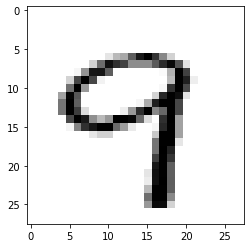

In [5]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


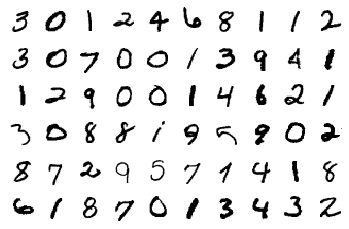

In [6]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# Model

In [0]:
class Net(nn.Module):
    def __init__(self):
        """ This function instantiates all the model layers """
        super(Net, self).__init__()

        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3),
            nn.ReLU()
        )  # Input: 28x28x1 | Output: 26x26x16 | RF: 3x3

        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3),
            nn.ReLU()
        )  # Input: 26x26x16 | Output: 24x24x16 | RF: 5x5

        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3),
            nn.ReLU()
        )  # Input: 24x24x16 | Output: 22x22x16 | RF: 7x7

        self.pool = nn.MaxPool2d(2, 2)  # Input: 22x22x16 | Output: 11x11x16 | RF: 8x8

        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3),
            nn.ReLU()
        )  # Input: 11x11x16 | Output: 9x9x16 | RF: 12x12

        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3),
            nn.ReLU()
        )  # Input: 9x9x16 | Output: 7x7x16 | RF: 16x16

        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3),
            nn.ReLU()
        )  # Input: 7x7x16 | Output: 5x5x16 | RF: 20x20

        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3),
            nn.ReLU()
        )  # Input: 5x5x16 | Output: 3x3x16 | RF: 24x24

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=3)
        )  # Input: 3x3x16 | Output: 1x1x10 | RF: 28x28

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params

In [8]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             160
              ReLU-2           [-1, 16, 26, 26]               0
            Conv2d-3           [-1, 16, 24, 24]           2,320
              ReLU-4           [-1, 16, 24, 24]               0
            Conv2d-5           [-1, 16, 22, 22]           2,320
              ReLU-6           [-1, 16, 22, 22]               0
         MaxPool2d-7           [-1, 16, 11, 11]               0
            Conv2d-8             [-1, 16, 9, 9]           2,320
              ReLU-9             [-1, 16, 9, 9]               0
           Conv2d-10             [-1, 16, 7, 7]           2,320
             ReLU-11             [-1, 16, 7, 7]               0
           Conv2d-12             [-1, 16, 5, 5]           2,320
             ReLU-13             [-1, 16, 5, 5]               0
           Conv2d-14             [

# Training and Testing

In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [10]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15

for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.2257975935935974 Batch_id=468 Accuracy=29.86: 100%|██████████| 469/469 [00:11<00:00, 40.54it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.4224, Accuracy: 8628/10000 (86.28%)

EPOCH: 1


Loss=0.19199307262897491 Batch_id=468 Accuracy=93.76: 100%|██████████| 469/469 [00:11<00:00, 39.52it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1237, Accuracy: 9615/10000 (96.15%)

EPOCH: 2


Loss=0.04348142072558403 Batch_id=468 Accuracy=96.78: 100%|██████████| 469/469 [00:11<00:00, 39.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0823, Accuracy: 9745/10000 (97.45%)

EPOCH: 3


Loss=0.11015389114618301 Batch_id=468 Accuracy=97.54: 100%|██████████| 469/469 [00:11<00:00, 40.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0606, Accuracy: 9803/10000 (98.03%)

EPOCH: 4


Loss=0.05035154148936272 Batch_id=468 Accuracy=97.96: 100%|██████████| 469/469 [00:11<00:00, 42.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0536, Accuracy: 9823/10000 (98.23%)

EPOCH: 5


Loss=0.01870577037334442 Batch_id=468 Accuracy=98.23: 100%|██████████| 469/469 [00:11<00:00, 49.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0529, Accuracy: 9826/10000 (98.26%)

EPOCH: 6


Loss=0.08069847524166107 Batch_id=468 Accuracy=98.56: 100%|██████████| 469/469 [00:11<00:00, 40.32it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0623, Accuracy: 9800/10000 (98.00%)

EPOCH: 7


Loss=0.008508791215717793 Batch_id=468 Accuracy=98.53: 100%|██████████| 469/469 [00:11<00:00, 40.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0433, Accuracy: 9850/10000 (98.50%)

EPOCH: 8


Loss=0.034742873162031174 Batch_id=468 Accuracy=98.76: 100%|██████████| 469/469 [00:11<00:00, 41.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0433, Accuracy: 9860/10000 (98.60%)

EPOCH: 9


Loss=0.017894020304083824 Batch_id=468 Accuracy=98.85: 100%|██████████| 469/469 [00:11<00:00, 40.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0448, Accuracy: 9852/10000 (98.52%)

EPOCH: 10


Loss=0.020936956629157066 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:11<00:00, 39.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0344, Accuracy: 9887/10000 (98.87%)

EPOCH: 11


Loss=0.009007479064166546 Batch_id=468 Accuracy=98.98: 100%|██████████| 469/469 [00:11<00:00, 40.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0389, Accuracy: 9870/10000 (98.70%)

EPOCH: 12


Loss=0.010459989309310913 Batch_id=468 Accuracy=99.10: 100%|██████████| 469/469 [00:11<00:00, 42.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0355, Accuracy: 9886/10000 (98.86%)

EPOCH: 13


Loss=0.0638861358165741 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:11<00:00, 42.44it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0422, Accuracy: 9880/10000 (98.80%)

EPOCH: 14


Loss=0.0053622424602508545 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:10<00:00, 43.03it/s]



Test set: Average loss: 0.0371, Accuracy: 9879/10000 (98.79%)



# Result Visualization

Text(0.5, 1.0, 'Test Accuracy')

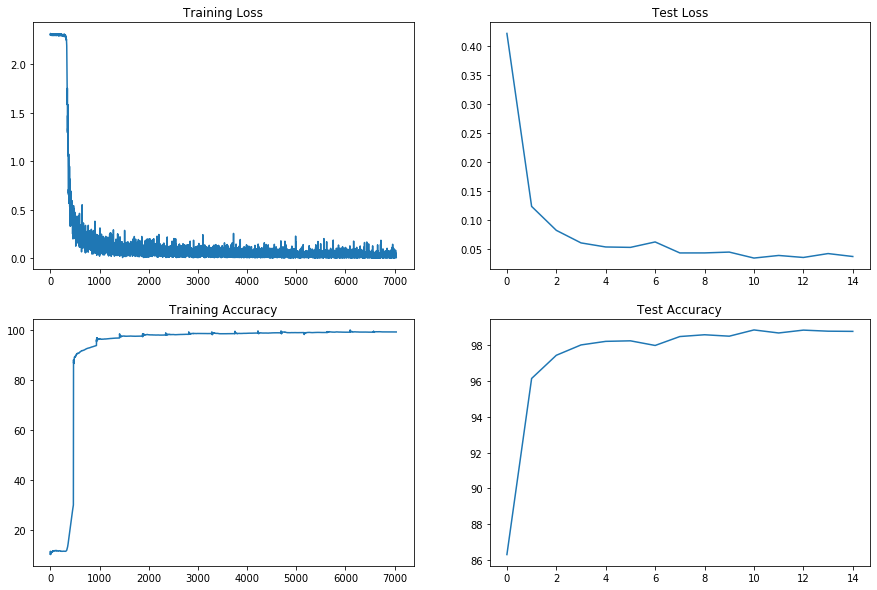

In [11]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")